In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from photutils.aperture import CircularAnnulus, CircularAperture, aperture_photometry, ApertureStats


In [36]:
n_pix = 32
x,y = np.meshgrid(np.arange(n_pix), np.arange(n_pix))

In [58]:
sigma = 2.
x_pos = n_pix/2+.1012
y_pos = n_pix/2+.3365
gaussian = np.exp(-0.5*((x-x_pos)**2+(y-y_pos)**2)/sigma**2)

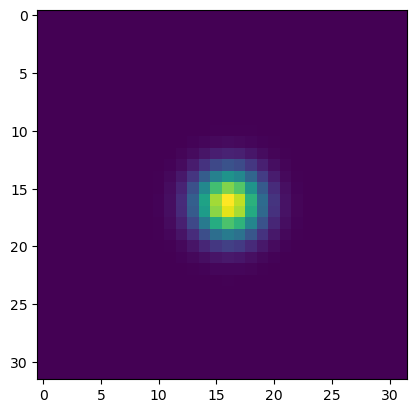

In [59]:
plt.imshow(gaussian)

In [60]:
x1, y1 = centroid_quadratic(gaussian)

In [61]:
x1,y1

(16.089557687331695, 16.29898707529465)

In [62]:
x1, y1 = centroid_com(gaussian)
x1,y1

(16.101199999999942, 16.336499999999848)

In [63]:
noise = np.random.normal(size=(n_pix,n_pix), scale=.05)

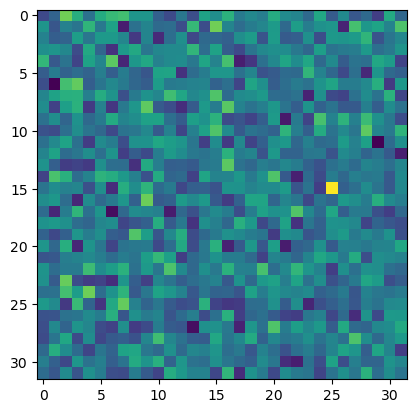

In [64]:
plt.imshow(noise)

In [65]:
data = noise + gaussian

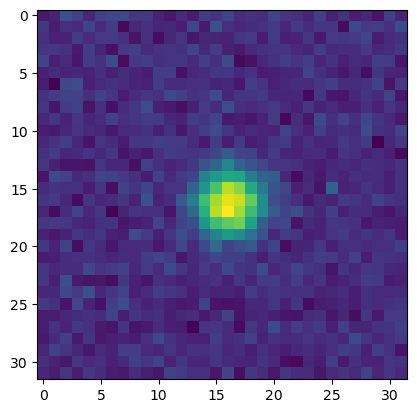

In [66]:
plt.imshow(data)

In [67]:
x1, y1 = centroid_com(data)
print(x1,y1)

16.050679321779704 15.066573512156129


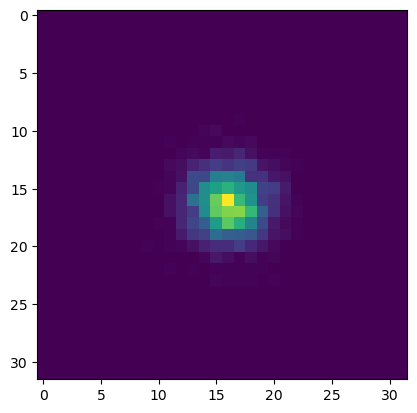

In [68]:
plt.imshow(np.random.poisson(gaussian*100))

In [69]:
np.unique(np.random.poisson(gaussian*100))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,
        28,  29,  30,  35,  36,  37,  39,  40,  45,  46,  47,  50,  56,
        57,  58,  59,  65,  71,  72,  73,  75,  78,  79,  85,  86,  94,
       106])

In [70]:
x1, y1 = centroid_com(np.random.poisson(gaussian*100))
print(x1,y1)

16.08856808427624 16.266874756145143


In [71]:
positions = [(x_pos, y_pos)]

aperture = CircularAperture(positions, r=6)

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)


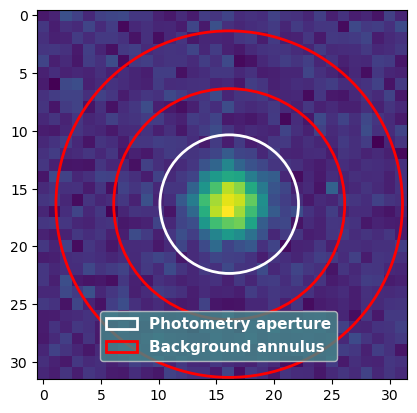

In [72]:
plt.imshow(data)
ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

In [54]:
positions

[(16.1012, 16.3365)]

In [55]:
phot_table = aperture_photometry(data, aperture)
aperstats = ApertureStats(data, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = aperture.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

In [56]:
phot_bkgsub

75.22303602209624


In [57]:
gaussian.sum()

222.57256984489123

In [21]:
# ok, now we can make a large stack of 1k or 10k of nxn images. Add noise in a vecorized way, 
# loop over each slice and do apperture photometry. Then can compute mean counts, and stdev counts measured in phot
# That gives us SNR. then also measure centroid stdev in both dimensions

In [22]:
np.random.seed(42)

gaussian = gaussian/gaussian.sum()

n_images = 10000
data_sum = 1000
sky_scale = 5
gaussian_3d = np.repeat(gaussian[:, :, np.newaxis], n_images, axis=2)

In [23]:
# Sky realizations as gaussian noise
sky = np.random.normal(size=gaussian_3d.shape, scale=sky_scale)

In [24]:
# apply Poisson noise to object
data = np.random.poisson(gaussian_3d * data_sum) + sky

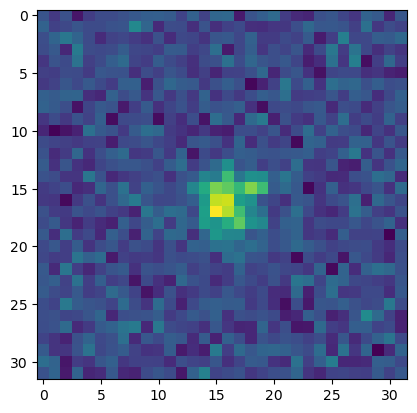

In [25]:
plt.imshow(data[:,:,0])

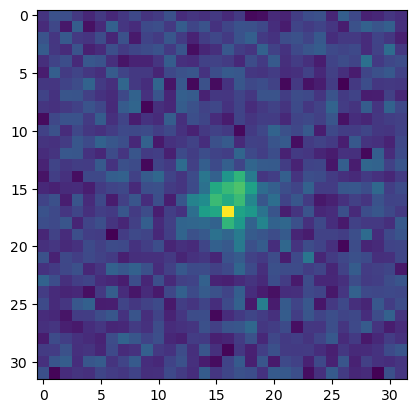

In [26]:
plt.imshow(data[:,:,10])

In [27]:
# Run a Monte Carlo where we vary the object size, object number of counts, and sky background

np.random.seed(42)
x_pos = n_pix/2+.1012 # position in the center, with a random sub-pix offset
y_pos = n_pix/2+.3365 # position in the center, with a random sub-pix offset
n_images = 1000

aperture = CircularAperture(positions, r=6)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)



# number of counts to have in the object
data_sums = [100, 1000, 2500, 5000, 10000, 25000, 50000]
# scales for Gaussain sky background
sky_scales = [0.1, 0.5, 1., 2.5, 5., 10., 100., 200.]
# object sizes
sigmas = [0.5, 1., 1.5, 2., 3., 6.]

results = []

for data_sum in data_sums:
    for sky_scale in sky_scales:
        for sigma in sigmas:
            # source object
            gaussian = np.exp(-0.5*((x-x_pos)**2+(y-y_pos)**2)/sigma**2)
            # normalize and set total number of counts
            gaussian = gaussian/gaussian.sum()*data_sum
            # broadcast
            gaussian_3d = np.repeat(gaussian[:, :, np.newaxis], n_images, axis=2)
            sky = np.random.normal(size=gaussian_3d.shape, scale=sky_scale)
            data = np.random.poisson(gaussian_3d) + sky
            x1s = []
            y1s = []
            fluxes = []
            # For each frame, fit the centroid and do apperture photometry
            for i in np.arange(data.shape[-1]):
                ds = data[:,:,i]
                
                x1, y1 = centroid_com(ds)
                x1s.append(x1)
                y1s.append(y1)

                phot_table = aperture_photometry(ds, aperture)
                aperstats = ApertureStats(ds, annulus_aperture)
                bkg_mean = aperstats.mean
                aperture_area = aperture.area_overlap(ds)
                total_bkg = bkg_mean * aperture_area
                phot_bkgsub = phot_table['aperture_sum'] - total_bkg
                fluxes.append(phot_bkgsub.max())
            
            results.append([data_sum, sky_scale, sigma, np.mean(fluxes), np.std(fluxes), np.std(x1s), np.std(y1s) ])

In [28]:
results = np.array(results)

In [29]:
snr = results[:,3]/results[:,4]

Text(0, 0.5, 'image sigma')

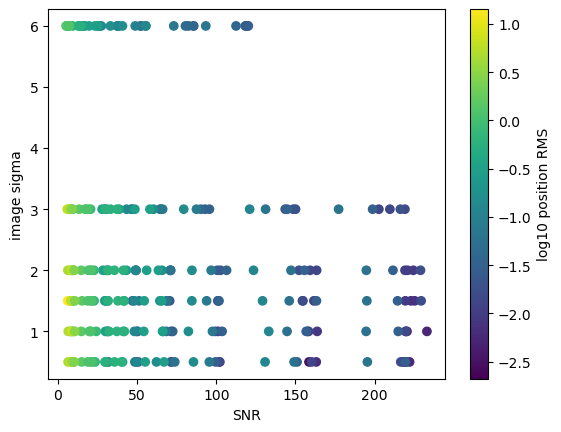

In [30]:
good = np.where(snr > 5)[0]
plt.scatter(snr[good], results[:,2][good], c=np.log10(results[:,5][good]))
cb = plt.colorbar()
cb.set_label('log10 position RMS')
plt.xlabel('SNR')
plt.ylabel('image sigma')

In [31]:
# Predicted error in centroid position is object FWHM/SNR
pred_error = results[:,2]*2.35/snr

Text(0, 0.5, 'pred-actual/pred')

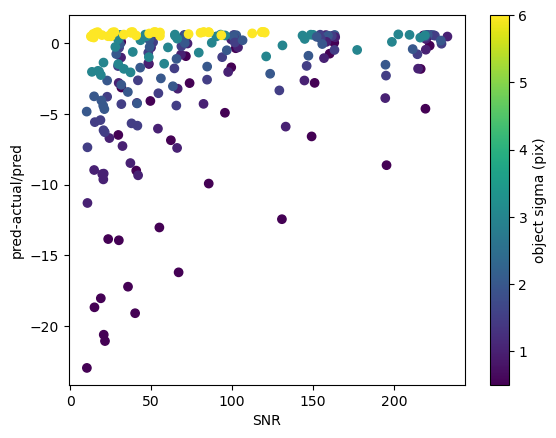

In [32]:
good = np.where(snr > 10)[0]
resid = (pred_error-results[:,6])/pred_error
plt.scatter(snr[good], resid[good], c=results[:,2][good])
cb = plt.colorbar()
cb.set_label('object sigma (pix)')

plt.xlabel('SNR')
plt.ylabel('pred-actual/pred')

Text(0, 0.5, 'position RMS')

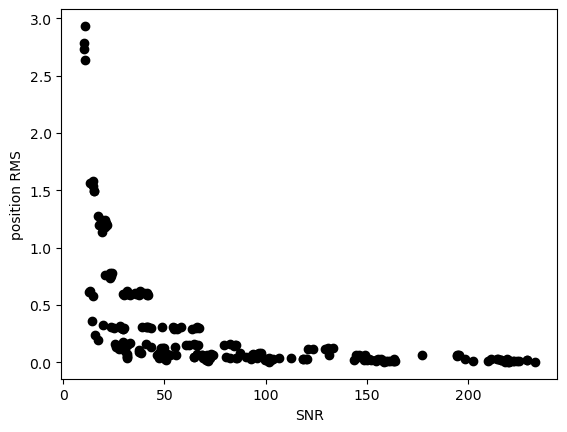

In [33]:
plt.plot(snr[good], results[:,5][good], 'ko')
plt.xlabel('SNR')
plt.ylabel('position RMS')

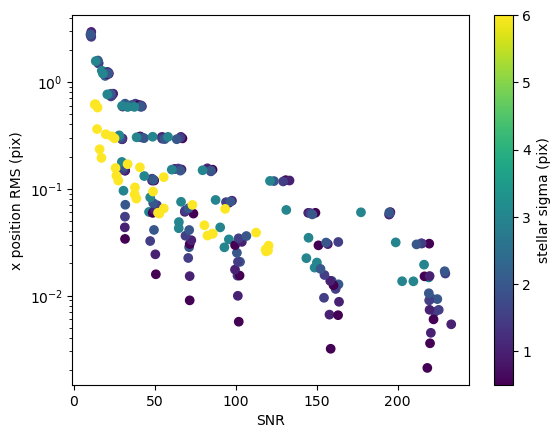

In [34]:
fig, ax = plt.subplots()

ack = ax.scatter(snr[good], results[:,5][good], c=results[:,2][good])
ax.set_xlabel('SNR')
ax.set_ylabel('x position RMS (pix)')
cb = plt.colorbar(ack)
cb.set_label('stellar sigma (pix)')
ax.set_yscale("log")

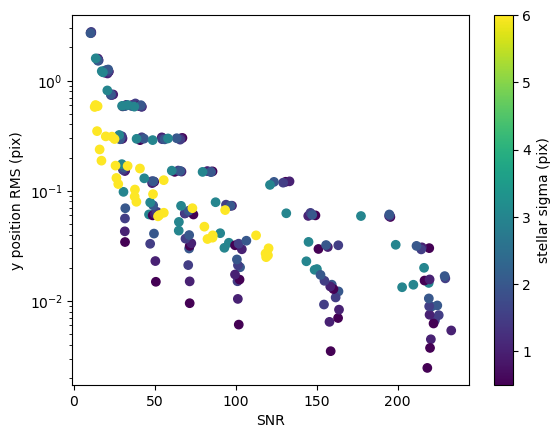

In [35]:
fig, ax = plt.subplots()

ack = ax.scatter(snr[good], results[:,6][good], c=results[:,2][good])
ax.set_xlabel('SNR')
ax.set_ylabel('y position RMS (pix)')
cb = plt.colorbar(ack)
cb.set_label('stellar sigma (pix)')
ax.set_yscale("log")